In [26]:
# Install the required libraries
#SAM
!pip3 install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip3 install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip3 install datasets
!pip3 install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip3 install patchify

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qnl0m9ka
  Running command git clone -q https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qnl0m9ka
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Get the data ready to train 

In [1]:
# imports

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# this function will be used to get an array of images from a folder

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array


## Sort, crop, and mask all the images

In [2]:
# this is based on if the image has a white pixel at 25, 100
# ussually this seperates the two image types

def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

folder_path_val = './data/val_images'
folder_path_train = './data/training_images'

train_array = read_images_to_array(folder_path_train)
val_array = read_images_to_array(folder_path_val)

# use the split function 

training_masks, training_raw = split_images(train_array) 
val_masks, val_raw = split_images(val_array) 


To test out if the function above works:

In [3]:
print(len(val_raw)) 
print(len(val_masks)) 
print(len(training_raw)) 
print(len(training_masks))

37
37
154
154


Text(0.5, 1.0, 'Raw Image (validation)')

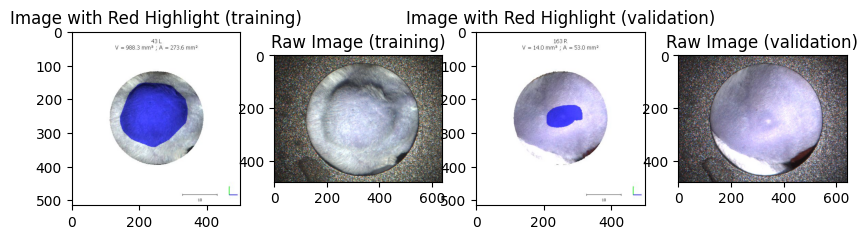

In [4]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train])
ax[0].set_title('Image with Red Highlight (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val]) 
ax[2].set_title("Image with Red Highlight (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [5]:
# this crops out the noise from the raw images

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

training_raw = crop_raw_images(training_raw)
val_raw = crop_raw_images(val_raw) 

In [6]:
print(len(val_raw)) 
print(len(val_masks)) 
print(len(training_raw)) 
print(len(training_masks))

37
37
154
154


Text(0.5, 1.0, 'Raw Image (validation)')

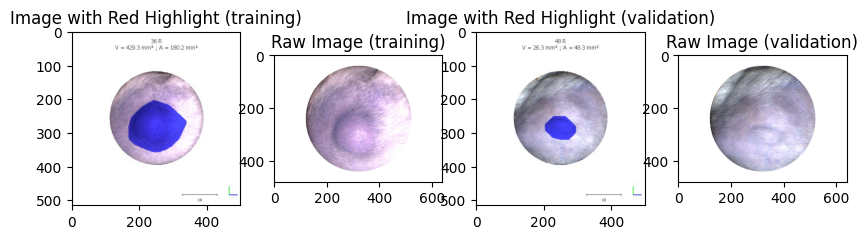

In [7]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train])
ax[0].set_title('Image with Red Highlight (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val]) 
ax[2].set_title("Image with Red Highlight (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [8]:
print(len(val_raw)) 
print(len(val_masks)) 
print(len(training_raw)) 
print(len(training_masks))

37
37
154
154


In [9]:
import numpy as np
import cv2

def crop_masks(image_array):
    cropped_masks = []

    for image in image_array:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (250, 257), 135, (255, 255, 255), -1)

        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask dimensions do not match.")

        res = cv2.bitwise_and(image, image, mask=mask)
        res[mask == 0] = 255

        cropped_masks.append(res)

    return cropped_masks

training_masks = crop_masks(training_masks)
val_masks = crop_masks(val_masks)


Text(0.5, 1.0, 'Raw Image (validation)')

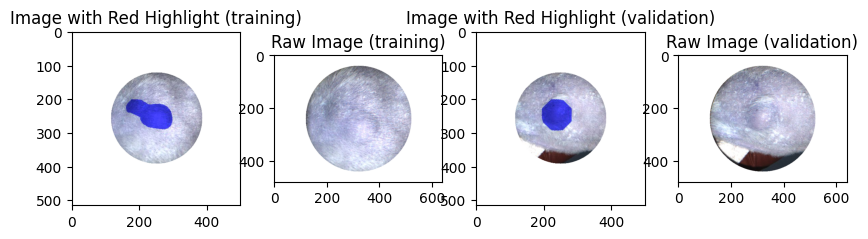

In [10]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train])
ax[0].set_title('Image with Red Highlight (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val]) 
ax[2].set_title("Image with Red Highlight (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [11]:
# function to turn the red region in the masks to binary masks 

def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

training_masks = create_binary_masks(training_masks) 
val_masks = create_binary_masks(val_masks)

Text(0.5, 1.0, 'Raw Image (validation)')

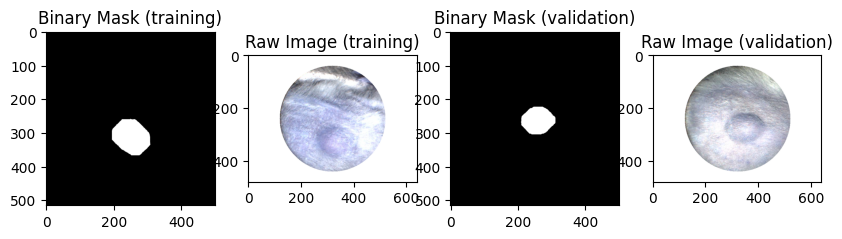

In [12]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [13]:
from PIL import Image
import numpy as np

def resize_binary_masks(image_array): 
    
    resized_binary_masks = []
    
    for image in image_array: 
        
        # crop 
        y=0
        x=0
        h=480
        w=640
        
        cropped_image = image[y:y+h, x:x+w]
        
        padding = 70 
        
        padded_img = cv2.copyMakeBorder(cropped_image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        resized_binary_masks.append(padded_img) 
    
    return resized_binary_masks

training_masks = resize_binary_masks(training_masks) 
val_masks = resize_binary_masks(val_masks)

Text(0.5, 1.0, 'Raw Image (validation)')

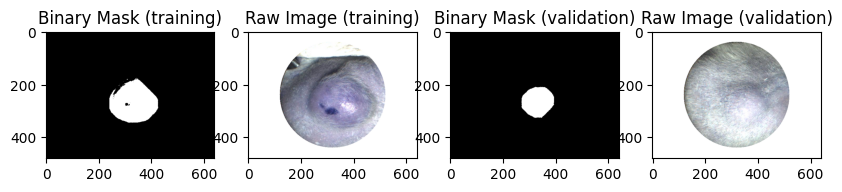

In [14]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [15]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

Now we have to resize the images in order to use them for training effectivly:

In [16]:
# now that we see that all the data can fit within 256x256
# we can write code that will crop out the images 

def crop_images(image_array): 
    
    cropped_images = []
    
    for i in range(len(image_array) -1): 
        
        image = image_array[i]
        
        image_height, image_width = image.shape[:2]
        
        # Bounding box dimensions
        box_width, box_height = 256, 256

        x_top_left = (image_width - box_width) // 2
        y_top_left = (image_height - box_height) // 2
        x_bottom_right = x_top_left + box_width
        y_bottom_right = y_top_left + box_height
        
        cropped_image = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
        cropped_images.append(cropped_image)
                              
    return cropped_images 
                              
training_raw = crop_images(training_raw) 
training_masks = crop_images(training_masks) 

val_raw = crop_images(val_raw) 
val_masks = crop_images(val_masks)

Text(0.5, 1.0, 'Raw Image (validation)')

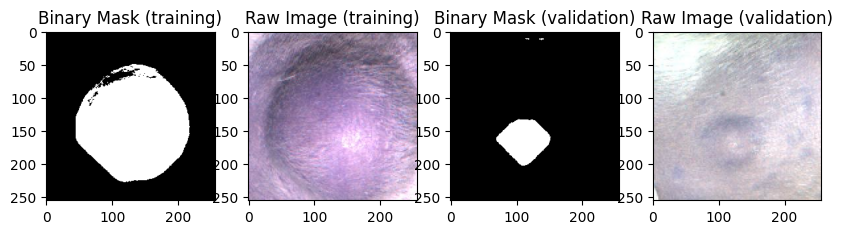

In [17]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

def augment_image_array(image_array_raw, image_array_binary): 

    for i in range(len(image_array_raw) - 1):
        
        image_raw = image_array_raw[i]
        image_binary = image_array_binary[i]
        
        flipped_image_raw = cv2.flip(image_raw,1) 
        flipped_image_binary = cv2.flip(image_binary,1)
        
        # random angle 
        angle = random.uniform(-30,30) 
        (h, w) = flipped_image_raw.shape[:2]
        center = (w // 2, h // 2)
        
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        augmented_image_raw = cv2.warpAffine(flipped_image_raw, M, (w, h))
        augmented_image_binary = cv2.warpAffine(flipped_image_binary, M, (w, h))
        
        image_array_raw.append(augmented_image_raw) 
        image_array_binary.append(augmented_image_binary) 
        
    return image_array_raw, image_array_binary

for i in range(3): 
    training_raw, training_masks = augment_image_array(training_raw, training_masks)
    val_raw, val_masks = augment_image_array(val_raw, val_masks)

Now to test if the augmentation function worked correctly 

In [ ]:
# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_masks[rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_raw[rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_masks[rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_raw[rand_val]) 
ax[3].set_title("Raw Image (validation)")

# Create the dataset

In [ ]:
# now create a dataset with these images 

# convert lists to arrays
training_raw = np.array(training_raw) 
training_masks = np.array(training_masks) 

val_raw = np.array(val_raw) 
val_masks = np.array(val_masks) 

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [Image.fromarray(img) for img in training_raw],
    "label": [Image.fromarray(mask) for mask in training_masks],
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_raw],
    "label": [Image.fromarray(mask) for mask in val_masks],
}

# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [ ]:
print("Training images shape:", training_raw.shape)
print("Training masks shape:", training_masks.shape)
print("Validation images shape:", val_raw.shape)
print("Validation masks shape:", val_masks.shape)


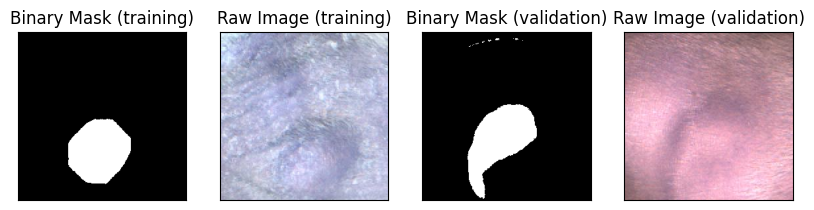

In [57]:
# now to check that everything is working 

# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_dataset["label"][rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_dataset["image"][rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_dataset["label"][rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_dataset["image"][rand_val]) 
ax[3].set_title("Raw Image (validation)")

# Hide axis ticks and labels
for axe in ax:
    axe.set_xticks([])
    axe.set_yticks([])
    axe.set_xticklabels([])
    axe.set_yticklabels([])

# Display the images side by side
plt.show()

In [58]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

# Train the Model

In [32]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [60]:
from torch.utils.data import random_split, DataLoader

training_dataset = SAMDataset(dataset=training_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)


train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 


In [61]:
example = training_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [62]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [63]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [64]:
batch["pixel_values"].shape

torch.Size([2, 3, 1024, 1024])

In [65]:
batch["input_boxes"].shape

torch.Size([2, 1, 4])

In [34]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [35]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [68]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Training loop
    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Logging training results
    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean(epoch_losses)}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(val_dataloader):
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

    # Logging validation results
    print(f'Mean validation loss: {mean(val_losses)}')
    
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "./models/mito_model_checkpoint2.pth")



100%|██████████| 153/153 [00:40<00:00,  3.74it/s]


EPOCH: 0
Mean training loss: -39760.985900330386


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Mean validation loss: -59589.266276041664


100%|██████████| 153/153 [00:40<00:00,  3.82it/s]


EPOCH: 1
Mean training loss: -192555.7115502451


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Mean validation loss: -143609.59917534722


100%|██████████| 153/153 [00:40<00:00,  3.81it/s]


EPOCH: 2
Mean training loss: -357727.27435661765


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Mean validation loss: -232647.26605902778


100%|██████████| 153/153 [00:40<00:00,  3.80it/s]


EPOCH: 3
Mean training loss: -544270.2824754902


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Mean validation loss: -340940.61805555556


100%|██████████| 153/153 [00:40<00:00,  3.81it/s]


EPOCH: 4
Mean training loss: -771987.1993464052


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Mean validation loss: -477493.9010416667


100%|██████████| 153/153 [00:40<00:00,  3.80it/s]


EPOCH: 5
Mean training loss: -1060223.8316993464


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Mean validation loss: -644865.8819444445


100%|██████████| 153/153 [00:40<00:00,  3.81it/s]


EPOCH: 6
Mean training loss: -1417480.3946078431


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Mean validation loss: -854354.7604166666


100%|██████████| 153/153 [00:40<00:00,  3.81it/s]


EPOCH: 7
Mean training loss: -1861771.5641339868


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Mean validation loss: -1109363.6927083333


100%|██████████| 153/153 [00:40<00:00,  3.80it/s]


EPOCH: 8
Mean training loss: -2391060.614379085


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Mean validation loss: -1427154.8368055555


100%|██████████| 153/153 [00:40<00:00,  3.81it/s]


EPOCH: 9
Mean training loss: -3043045.0939542484


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Mean validation loss: -1804465.951388889


# Test the model 

In [36]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [37]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./models/mito_model_checkpoint2.pth"))

<All keys matched successfully>

In [38]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

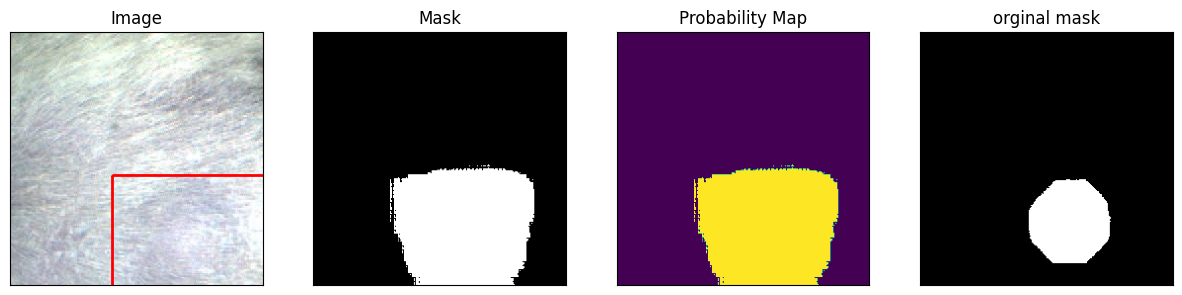

In [59]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# let's take a random training example
idx = random.randint(0, training_raw.shape[0]-1)

# load image
test_image = training_dataset["image"][idx]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(training_dataset["label"][idx])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

bbox = prompt  # Assuming prompt is the bounding box coordinates
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask
axes[3].imshow(training_masks[idx], cmap = "gray")
axes[3].set_title("orginal mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [51]:
!nvidia-smi

Mon Jul  1 13:00:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:65:00.0 Off |                    0 |
| N/A   36C    P0             72W /  300W |    3627MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----